In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

In [2]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]
num_root_tweets = len(root_tweet_names)

In [3]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = []
for i in range(num_root_tweets):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
        
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].apply(pd.to_numeric, errors='coerce')
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].fillna(0)
    
    tweet_dfs.append(tweet_df)

In [4]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = []
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times.append(reaction_time)
    return reaction_times

In [5]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet

In [10]:
log_s_j_x = []
for i in range(num_root_tweets):
    s_j_x = sorted(generate_reaction_times(tweet_dfs[i]))
    log_s_j_x.append([np.log(j.seconds) for j in s_j_x])


(array([  4.,  13.,  20.,  43.,  53.,  54.,  43.,  31.,  16.,  26.]),
 array([  2.83321334,   3.68563022,   4.53804711,   5.39046399,
          6.24288087,   7.09529775,   7.94771463,   8.80013151,
          9.65254839,  10.50496527,  11.35738215]),
 <a list of 10 Patch objects>)

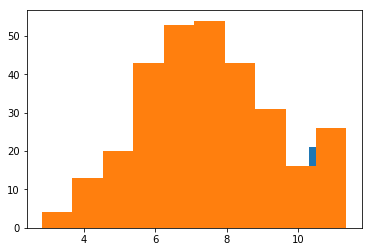

In [21]:
plt.hist(log_s_j_x[1])
plt.hist(log_s_j_x[4])
